#The Angry User Experiment

## Human Factors & Behavioural Biometrics

This notebook was created to explore the relationship (if any!) between user emotions and/or fatigue level and keybaord and mouse usage.

I use Pandas for data analysis, and the Seaborn package for data visualization. The keyboard and mouse capture data was originally kept in SQLite and I have stuck with that. 

Here is the simple experiment layout. The typing of these instructions was actually the data to be captured:


> 1. Start keylogger.
> 2. Type up this experimental outline.
> 3. Calm User, just typing something up. A few instructions, a message maybe. Click to enlarge text window. 
> 4. A bit of window movement. Dragging text window around the page.
> 5. Bored User: tracks mouse back and forth … 
> 6. User reading document with mouse to help.
> 7. User highlights data to read it.
> 8. User loses mouse between screens.
> 9. User with extremem mouse jerk.
> 10. User picking up mouse to move its postion on the screen.
> 11. User angrily smashes key board.


> Jk,uiolhjmASopwe-1jk,zsdjik,lxsfdfgbrfvd78uikj kl;'/tgyh xfdc

> 12. Some more mouse jerk!
> 13. Typing a sfast as I can because I am hurridly trying to get a message out to someone, seriously as fast as I can > and somehow very accurately as well.
> 14. Perhaps a user who clicks a lot when bored or annoyed. Or they just can't wait when pushing a "button".
> 15. Turn of keylogger.


In [1]:
import pandas as pd
import seaborn as sns
import math as mt
import matplotlib.pyplot as plt
import time as clk
from datetime import datetime,timedelta
import numpy as np
import os
import traceback as trace
import sqlite3
import BiometricFeatures as bf
%matplotlib inline

##Taking a Look at the Data

The experiment was done all at once and stored in a single file:

In [2]:
dbFile = 'data/experimentData.db'

###Get the key capture data. 

* **Time**: seconds since the epoch

* **Keycode**: one for each key of the keyboard. Most correspond to ASCII codes. 

* **Pressed**: Down(0) and Up(1) positions for keys and buttons.

In [3]:
db_is_new = not os.path.exists(dbFile)
conn = sqlite3.connect(dbFile)
if db_is_new:
  print 'Need to create schema'
keydataDF = pd.read_sql("SELECT time,keycode,pressed FROM keydata",conn)
keydataDF.head()

,time,keycode,pressed
0,1429711028522,1,0
1,1429711028834,1,1
2,1429711030815,161,0
3,1429711031049,84,0
4,1429711031127,84,1


###Get the mouse positional data.

* **(x,y)** = (0,0) is the top left-hand corner of the screen. Extended displays simple extend the x and y axes. 


In [4]:
mousedataDF = pd.read_sql("SELECT time,x,y FROM mousedata",conn)
mousedataDF.head()

,time,x,y
0,1429711026338,91,112
1,1429711026338,92,113
2,1429711026354,94,114
3,1429711026354,96,115
4,1429711026369,102,117


###Get the mouseclick data table:

* **Executable**: in which window the mouse was clicked.

In [5]:
mouseclickDF = pd.read_sql("SELECT time,user,executable,foregroundwindow,click,name,role,state,value,action,shortcutkey,description FROM mouseclicks",conn)
mouseclickDF.head()

,time,user,executable,foregroundwindow,click,name,role,state,value,action,shortcutkey,description
0,1429711092747,henderson.j,ONENOTE.EXE,The Angry User Experiment - Microsoft Office O...,left,-,client,focusable,-,-,-,-
1,1429711094619,henderson.j,ONENOTE.EXE,The Angry User Experiment - Microsoft Office O...,left,-,client,focusable,-,-,-,-
2,1429711096616,henderson.j,ONENOTE.EXE,The Angry User Experiment - Microsoft Office O...,left,-,client,focusable,-,-,-,-
3,1429711097708,henderson.j,ONENOTE.EXE,The Angry User Experiment - Microsoft Office O...,left,-,client,focusable,-,-,-,-
4,1429711111171,henderson.j,ONENOTE.EXE,The Angry User Experiment - Microsoft Office O...,left,-,client,focusable,-,-,-,-


### Get the editable text table.

* **Value**: the text that was typed.

**Note:** the timestamps correspond to when the user *finished* typing (i.e. moved away from the text box)

In [6]:
editableTextDF = pd.read_sql("SELECT time,user,executable,foregroundwindow,action,value FROM editabletext",conn)
editableTextDF.head()

,time,user,executable,foregroundwindow,action,value
0,1429711040581,henderson.j,ONENOTE.EXE,The Angry User Experiment - Microsoft Office O...,typed,TYpe up thesis experimental outline.
1,1429711112466,henderson.j,ONENOTE.EXE,The Angry User Experiment - Microsoft Office O...,typed,"CAlm USer, just typing something up. A few ins..."
2,1429711134899,henderson.j,ONENOTE.EXE,The Angry User Experiment - Microsoft Office O...,typed,DRagging text window areound the page.
3,1429711166879,henderson.j,ONENOTE.EXE,The Angry User Experiment - Microsoft Office O...,typed,BOred USer : tracks mouse back and forth ...
4,1429711203835,henderson.j,ONENOTE.EXE,The Angry User Experiment - Microsoft Office O...,typed,RUSer reading document with mouse to help.


## Decoding keycodes:

####To verify that the keycodes meant what I thought they meant (they often did not!), I performed the following mini experiment:


Type the following and capture the keycode information:

> 1. Letters
> 2. Two mouse right clicks
> 3. Ctrl, Shift, Alt, CapsLock x2, Window x2, tab, esc
> 4. Two mouse left clicks
> 5. Numbers
> 6. Two right clicks
> 7. Symbols
> 8. Two left clicks
> 9. Shift-letters
> 10. Two right clicks
> 11. Shift-numbers
> 12. Two left clicks
> 13. Shift-symbols
> 14. Two right clicks
> 15. Enter,Backspace,delete,insert,home,End,Pup,Pdown,up arrow,down,left,right
> 16. Two left clicks

*This is what was typed:*


> Qwertyuioplkjhgfdsazxcvbnm1234567890`-=\][;'/.,QWERTYUIOPLKJHGFDSAZXCVBNM!@#$%^&*()~_+|}{:"?><
	
	


###Get the data: 

In [7]:
dbFile = 'data/keycodeData.db'
db_is_new = not os.path.exists(dbFile)
conn = sqlite3.connect(dbFile)
if db_is_new:
  print 'Need to create schema'
qwertyDF = pd.read_sql("SELECT time,keycode,pressed FROM keydata",conn)
qwertyTextDF = pd.read_sql("SELECT time,user,executable,foregroundwindow,action,value FROM editabletext",conn)
qwertyTextDF.head()

,time,user,executable,foregroundwindow,action,value
0,1429715324250,henderson.j,explorer.exe,The Angry User Experiment - Microsoft Office O...,typed,qwertyuioplkjhgfdsazxcvbnm
1,1429715414481,henderson.j,ONENOTE.EXE,The Angry User Experiment - Microsoft Office O...,typed,"\t1234567890`-=\][;'/.,QWERTYUIOPLKJHGFDSAZXC..."


###Get the times when keys or mouse buttons were pressed down only:

In [8]:
downDF = qwertyDF.groupby('pressed').get_group(0)

### Mouse button codes:

In [9]:
mouseCodes = [1,2]
mouse = ['left click','right click']

###Letters:

In [10]:
letters = ['q','w','e','r','t','y','u','i','o','p','l','k','j','h','g','f','d','s','a','z','x','c','v','b','n','m']
letterCodes = [l for l in downDF['keycode'][downDF.index.get_loc(0):downDF.index.get_loc(54)] if not l in mouseCodes]

###Control key codes:

In [11]:
controls = ['Ctrl Left','Ctrl Right','Shift Left','Shift Right','Alt','Caps','Window','Tab','Esc','Spacebar']
controlCodes = [162,163,160,161,164,20,92,9,27,32]
control2 = ['Enter','Backspace','delete','insert','home','End','PgUp','PgDn','up','down','left','right']
control2Codes = [s for s in downDF['keycode'][downDF.index.get_loc(279):downDF.index.get_loc(305)] if not s in mouseCodes and not s in controlCodes]
controls.extend(control2)
controlCodes.extend(control2Codes)

###Numeric:

In [12]:
numbers = ['1','2','3','4','5','6','7','8','9','0']
numCodes = [n for n in downDF['keycode'][downDF.index.get_loc(90):downDF.index.get_loc(112)] if not n in mouseCodes]

###Symbols

In [13]:
symbols = ['`','-','=','\\',']','[',';','\'','/','.',',']
symbolCodes = [s for s in downDF['keycode'][downDF.index.get_loc(114):downDF.index.get_loc(138)] if not s in mouseCodes]

###Unknown:

In [14]:
unknownCodes = [120,121,112,113]

### Putting them together:

I associated a colour with each group of keys here to reference it later for some plots.

In [15]:
keyTypeColours = sns.xkcd_palette(["windows blue", "amber", "greyish", "faded green", "dusty purple","black"])
keyTypes = {'Control': {'keys': controls,'codes': controlCodes,'colour': keyTypeColours[0]},
            'Letters': {'keys': letters, 'codes': letterCodes,'colour': keyTypeColours[1]},
            'Numbers': {'keys': numbers, 'codes': numCodes,'colour': keyTypeColours[2]},
            'Mouse Buttons': {'keys': mouse, 'codes': mouseCodes,'colour': keyTypeColours[3]},
            'Symbols': {'keys': symbols, 'codes': symbolCodes,'colour': keyTypeColours[4]},
            'Unknown': {'keys': ['unknown' for c in unknownCodes],'codes': unknownCodes,'colour': keyTypeColours[5]}
            }
keyTypesDF = pd.DataFrame(keyTypes)
keyTypesDF

,Control,Letters,Mouse Buttons,Numbers,Symbols,Unknown
codes,"[162, 163, 160, 161, 164, 20, 92, 9, 27, 32, 1...","[81, 87, 69, 82, 84, 89, 85, 73, 79, 80, 76, 7...","[1, 2]","[49, 50, 51, 52, 53, 54, 55, 56, 57, 48]","[192, 189, 187, 220, 221, 219, 186, 222, 191, ...","[120, 121, 112, 113]"
colour,"(0.21568627451, 0.470588235294, 0.749019607843)","(0.996078431373, 0.701960784314, 0.0313725490196)","(0.482352941176, 0.698039215686, 0.454901960784)","(0.658823529412, 0.643137254902, 0.58431372549)","(0.509803921569, 0.372549019608, 0.529411764706)","(0.0, 0.0, 0.0)"
keys,"[Ctrl Left, Ctrl Right, Shift Left, Shift Righ...","[q, w, e, r, t, y, u, i, o, p, l, k, j, h, g, ...","[left click, right click]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 0]","[`, -, =, \, ], [, ;, ', /, ., ,]","[unknown, unknown, unknown, unknown]"


## Keyboard *DNA Profile*

Here I am adding some fields to the `keydataDF` dataframe:

* **Datetime**: converting the timestamps from seconds to a human readable format.

In [16]:
keydataDF['Datetime'] = pd.to_datetime(keydataDF['time'],unit='ms')
keydataDF=keydataDF.set_index('Datetime')
keydataDF.index = pd.DatetimeIndex(keydataDF.index)
keydataDF.index.names = ["Datetime"]
keytypes,keycolour,key = [],[],[]
for code in keydataDF['keycode']:
    for col in keyTypesDF.columns:
        codelist = keyTypesDF.loc['codes'][col]
        keylist = keyTypesDF.loc['keys'][col]
        if code in codelist:
            try:
                keytypes.append(col)
                keycolour.append(keyTypesDF.loc['colour'][col])
                key.append(keylist[codelist.index(code)])
            except:
                print code,col,codelist.index(code),len(codelist),len(keylist)
keydataDF['key'] = pd.Series(key,index=keydataDF.index)            
keydataDF['key type'] = pd.Series(keytypes,index=keydataDF.index)            
keydataDF['key colour'] = pd.Series(keycolour,index=keydataDF.index)            

keydataDF.head()

,time,keycode,pressed,key,key type,key colour
Datetime,,,,,,
2015-04-22 13:57:08.522000,1429711028522,1,0,left click,Mouse Buttons,"(0.482352941176, 0.698039215686, 0.454901960784)"
2015-04-22 13:57:08.834000,1429711028834,1,1,left click,Mouse Buttons,"(0.482352941176, 0.698039215686, 0.454901960784)"
2015-04-22 13:57:10.815000,1429711030815,161,0,Shift Right,Control,"(0.21568627451, 0.470588235294, 0.749019607843)"
2015-04-22 13:57:11.049000,1429711031049,84,0,t,Letters,"(0.996078431373, 0.701960784314, 0.0313725490196)"
2015-04-22 13:57:11.127000,1429711031127,84,1,t,Letters,"(0.996078431373, 0.701960784314, 0.0313725490196)"


I would like to look at my typing pattern, but the `keydataDF` table counts each key at least twice because of the 'pressed' column.

I'll just take out the initial Down(0) instance for each key:

In [17]:
rule = keydataDF['pressed']==0
keyGroups = keydataDF[rule].groupby('key type')

###First visualization of the data

Just a quick look at what I am typing and when.

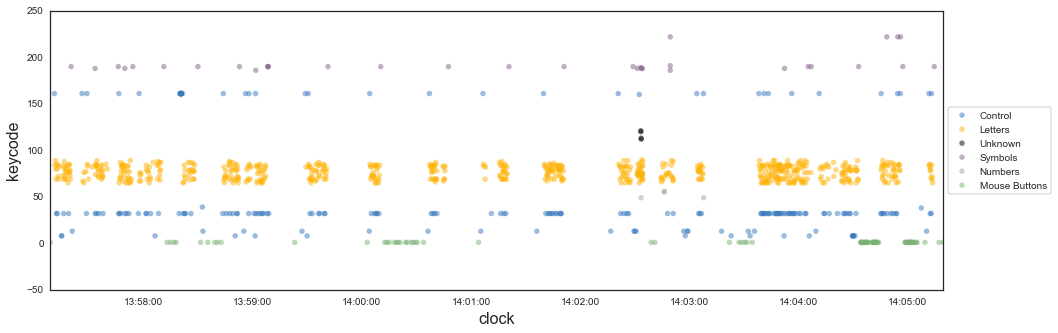

In [18]:
bf.printKeyTypeDNA(keyGroups,keydataDF)

It is hard to tell which part of the experiment happend when, so I will split up the data into chucks corresponding to each of the numbered points laid out in the initial experiment outline at the top of the notebook.

###Discovering the experimental steps in the data


Find the datetime ranges that correspond to each step of the experiment:  

In [19]:
editableTextDF['Datetime'] = pd.to_datetime(editableTextDF['time'],unit='ms')
editableTextDF=editableTextDF.set_index('Datetime')
editableTextDF.index = pd.DatetimeIndex(editableTextDF.index)
editableTextDF.index.names = ["Datetime"]

labels,indices = [],[]
n = 0
for d,l in zip(editableTextDF.index,editableTextDF['value']):
    if len(l)<2:
        indices.pop()
        indices.append(d)
    else:    
        labels.append(str(n)+": "+l)
        indices.append(d)
        n+=1
labelsDF = pd.DataFrame({'label':pd.Series(labels,index=indices)})  
ranges = [(labelsDF.index[i-1],labelsDF.index[i]) if i > 0 else (mousedataDF.index[0],labelsDF.index[i]) for i in range(len(labelsDF))]
labelsDF["Mouse Data Ranges"] = pd.Series(ranges,index=labelsDF.index)
ranges = [(labelsDF.index[i-1],labelsDF.index[i]) if i > 0 else (keydataDF.index[0],labelsDF.index[i]) for i in range(len(labelsDF))]
labelsDF["Key Data Ranges"] = pd.Series(ranges,index=labelsDF.index)
labelsDF    

,label,Mouse Data Ranges,Key Data Ranges
2015-04-22 13:57:20.581000,0: TYpe up thesis experimental outline.,"(0, 2015-04-22 13:57:20.581000)","(2015-04-22 13:57:08.522000, 2015-04-22 13:57:..."
2015-04-22 13:58:32.466000,"1: CAlm USer, just typing something up. A few ...","(2015-04-22 13:57:20.581000, 2015-04-22 13:58:...","(2015-04-22 13:57:20.581000, 2015-04-22 13:58:..."
2015-04-22 13:58:54.899000,2: DRagging text window areound the page.,"(2015-04-22 13:58:32.466000, 2015-04-22 13:58:...","(2015-04-22 13:58:32.466000, 2015-04-22 13:58:..."
2015-04-22 13:59:26.879000,3: BOred USer : tracks mouse back and forth ...,"(2015-04-22 13:58:54.899000, 2015-04-22 13:59:...","(2015-04-22 13:58:54.899000, 2015-04-22 13:59:..."
2015-04-22 14:00:03.835000,4: RUSer reading document with mouse to help.,"(2015-04-22 13:59:26.879000, 2015-04-22 14:00:...","(2015-04-22 13:59:26.879000, 2015-04-22 14:00:..."
2015-04-22 14:00:36.158000,5: USer highlights data to read it.,"(2015-04-22 14:00:03.835000, 2015-04-22 14:00:...","(2015-04-22 14:00:03.835000, 2015-04-22 14:00:..."
2015-04-22 14:01:05.143000,6: USer loses mouse between screens.,"(2015-04-22 14:00:36.158000, 2015-04-22 14:01:...","(2015-04-22 14:00:36.158000, 2015-04-22 14:01:..."
2015-04-22 14:01:35.922000,7: USer with extremem mouse jerk.,"(2015-04-22 14:01:05.143000, 2015-04-22 14:01:...","(2015-04-22 14:01:05.143000, 2015-04-22 14:01:..."
2015-04-22 14:02:16.560000,8: USer picking up mouse to move its postion o...,"(2015-04-22 14:01:35.922000, 2015-04-22 14:02:...","(2015-04-22 14:01:35.922000, 2015-04-22 14:02:..."
2015-04-22 14:02:29.352000,9: USer angrily smashes key board.,"(2015-04-22 14:02:16.560000, 2015-04-22 14:02:...","(2015-04-22 14:02:16.560000, 2015-04-22 14:02:..."




Same plot as above, but now the different parts of the experiment have been separated out.



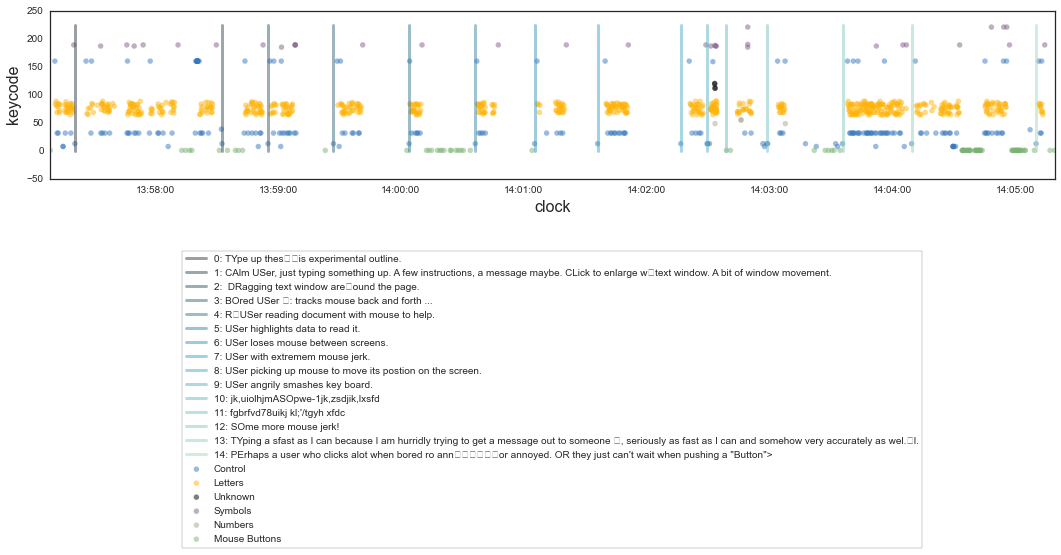

In [20]:
bf.printKeyTypeDNAwithLabels(keyGroups,keydataDF,labelsDF)

##Active / InActive times


In the above plots, you can see stretches of time when nothing happens. I would like to be able to identify times in that dataset that are *active* and other times that are *inactive*.

Here, I will aribitrarily set a minimum time for inactivity to be *10 seconds*.

In [21]:
tdeltas = np.diff(keydataDF.index.values)
tdeltas = np.insert(tdeltas,0,np.timedelta64(0,'ns'))
keydataDF['Delta time'] = pd.Series([td/np.timedelta64(1,'s') for td in tdeltas],index=keydataDF.index)
keyDF = keydataDF.reset_index()
deltaLim = keyDF['Delta time']>=10.0
keyDF[deltaLim]

,Datetime,time,keycode,pressed,key,key type,key colour,Delta time
574,2015-04-22 13:59:22.885000,1429711162885,1,0,left click,Mouse Buttons,"(0.482352941176, 0.698039215686, 0.454901960784)",14.196
668,2015-04-22 14:00:02.743000,1429711202743,1,0,left click,Mouse Buttons,"(0.482352941176, 0.698039215686, 0.454901960784)",21.497
836,2015-04-22 14:01:03.927000,1429711263927,1,0,left click,Mouse Buttons,"(0.482352941176, 0.698039215686, 0.454901960784)",16.459
902,2015-04-22 14:01:35.922000,1429711295922,13,0,Enter,Control,"(0.21568627451, 0.470588235294, 0.749019607843)",15.225
1018,2015-04-22 14:02:16.560000,1429711336560,13,0,Enter,Control,"(0.21568627451, 0.470588235294, 0.749019607843)",25.568


The above table identifies the rows in my original table `keydataDF` the represent the endpoints of breaks longer than my predefined *10 second* limit.

The **active** time ranges are then: 

In [22]:
irange = [i for i in keyDF[deltaLim].index]
activeRanges = [(keydataDF.iloc[irange[i]].name,keydataDF.iloc[irange[i+1]-1].name) for i in range(len(irange)-1)]
if not irange[0]==0: activeRanges.insert(0,(keydataDF.iloc[0].name,keydataDF.iloc[irange[0]-1].name))
if not irange[-1]==keyDF.index[-1]: activeRanges.append((keydataDF.iloc[irange[-1]].name,keydataDF.index[-1]))
activeRanges    

[(Timestamp('2015-04-22 13:57:08.522000'),
  Timestamp('2015-04-22 13:59:08.689000')),
 (Timestamp('2015-04-22 13:59:22.885000'),
  Timestamp('2015-04-22 13:59:41.246000')),
 (Timestamp('2015-04-22 14:00:02.743000'),
  Timestamp('2015-04-22 14:00:47.468000')),
 (Timestamp('2015-04-22 14:01:03.927000'),
  Timestamp('2015-04-22 14:01:20.697000')),
 (Timestamp('2015-04-22 14:01:35.922000'),
  Timestamp('2015-04-22 14:01:50.992000')),
 (Timestamp('2015-04-22 14:02:16.560000'),
  Timestamp('2015-04-22 14:05:19.159000'))]

Taking another look at my keydata *DNA profile*, now with the active times shaded in blue.

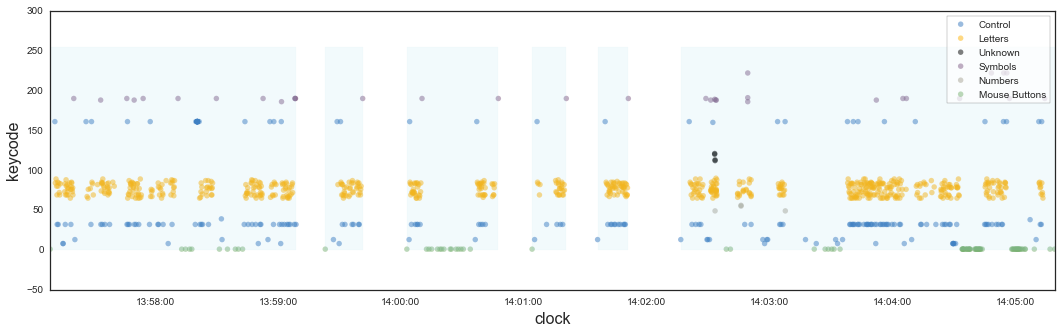

In [23]:
bf.printKeyTypeDNAwithActiveRanges(keyGroups,keydataDF,activeRanges)

#Keyboard Dynamics

I put the functions to calculate things like **key latency** (the time in seconds between the Up position of one key and the Down of the next) and **key duration** (how long you hold a key down when typing) into *BiometricFeatures.py*. 

There are several helper routines in there too to clean up the data (e.g. when a key is held down long enough it will register multiple Down(0) when we are most interested in the first one) and calculate things like a rolling mean or rolling count.

## Key Latency

Or the seconds between your finger leaving a key (U(1) position) and pressing the next key (Down(0) position).

In [24]:
latencyDF = bf.getKeyLatency(keydataDF)
latencyDF.head()

,time,keycode,pressed,key,key type,key colour,Delta time,latency
DateTime,,,,,,,,
2015-04-22 13:57:08.522000,1429711028522,1,0,left click,Mouse Buttons,"(0.482352941176, 0.698039215686, 0.454901960784)",0.000,0.000
2015-04-22 13:57:08.834000,1429711028834,1,1,left click,Mouse Buttons,"(0.482352941176, 0.698039215686, 0.454901960784)",0.312,0.312
2015-04-22 13:57:10.815000,1429711030815,161,0,Shift Right,Control,"(0.21568627451, 0.470588235294, 0.749019607843)",1.981,1.981
2015-04-22 13:57:11.049000,1429711031049,84,0,t,Letters,"(0.996078431373, 0.701960784314, 0.0313725490196)",0.234,0.234
2015-04-22 13:57:11.127000,1429711031127,84,1,t,Letters,"(0.996078431373, 0.701960784314, 0.0313725490196)",0.078,0.078


Let's take a look at a plot of this.

Here I will draw a scatterplot of the key latency data, a 1-second rolling count of how many keys are being pressed and a 1-second rolling mean.

The experimental steps are grouped and shaded in blue. 

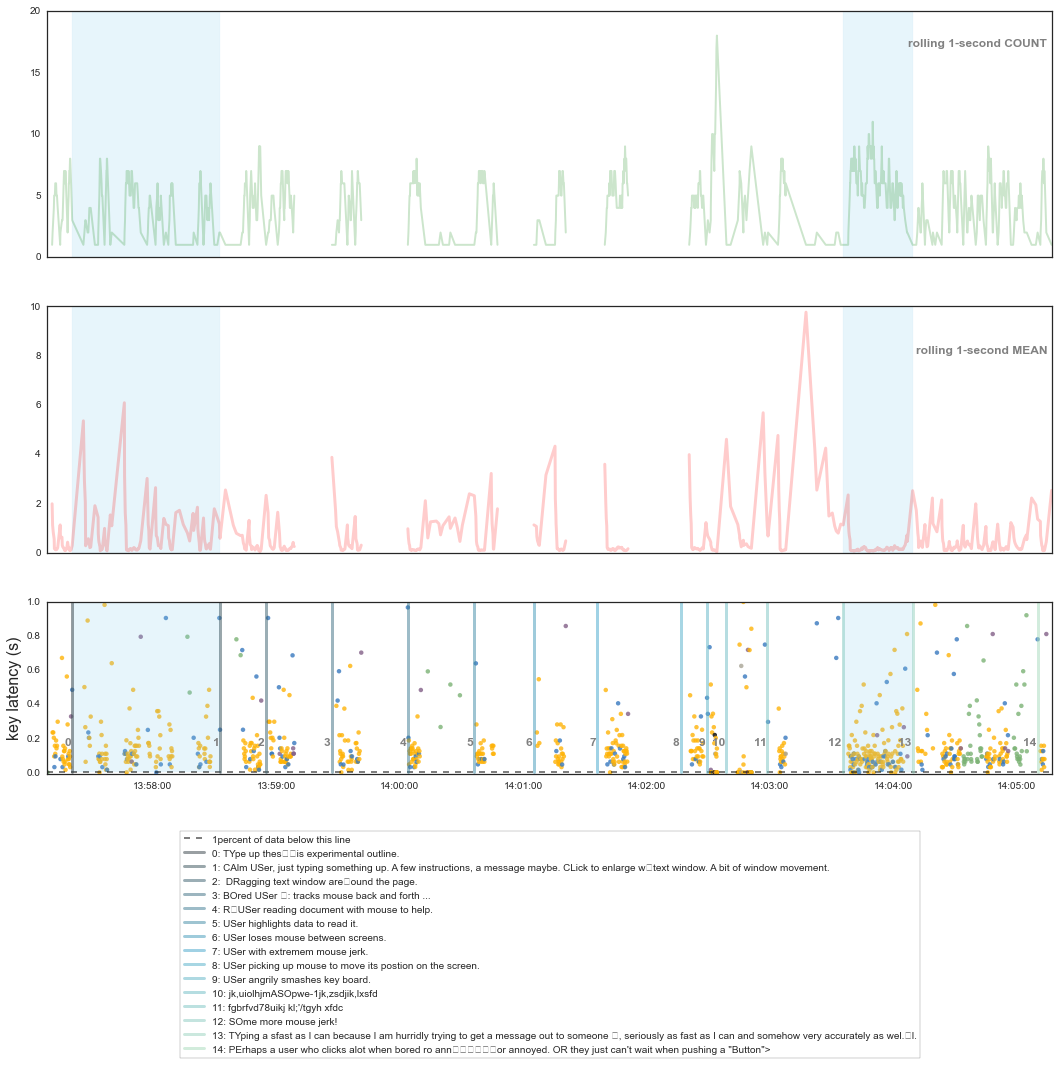

In [25]:
bf.printKeyLatency(latencyDF,labelsDF,activeRanges)

In the above graph, the shaded region on the left shows mean key latency for typing calmly, wheras on the right is typing as fast as I can under pressure. 

Even though individual key latency times span all ranges in both periods, the difference starts to show up in the top graph with the 1-second rolling count of how many keys are being pressed. 

**The mean key latency time shown in the middle graph is drastically different between the two periods, with more potential for detectability. **

## Key Duration

Or the seconds between your finger pushing Down(0) a key and letting it back UP(1) again. 

In [26]:
durationDF = bf.getKeyDuration(keydataDF)
durationDF.head()

,duration,key,key colour,key type,keycode
DateTime,,,,,
2015-04-22 13:57:08.834000,0.312,left click,"(0.482352941176, 0.698039215686, 0.454901960784)",Mouse Buttons,1
2015-04-22 13:58:13.481000,0.734,left click,"(0.482352941176, 0.698039215686, 0.454901960784)",Mouse Buttons,1
2015-04-22 13:58:15.821000,1.202,left click,"(0.482352941176, 0.698039215686, 0.454901960784)",Mouse Buttons,1
2015-04-22 13:58:17.240000,0.624,left click,"(0.482352941176, 0.698039215686, 0.454901960784)",Mouse Buttons,1
2015-04-22 13:58:17.786000,0.078,left click,"(0.482352941176, 0.698039215686, 0.454901960784)",Mouse Buttons,1


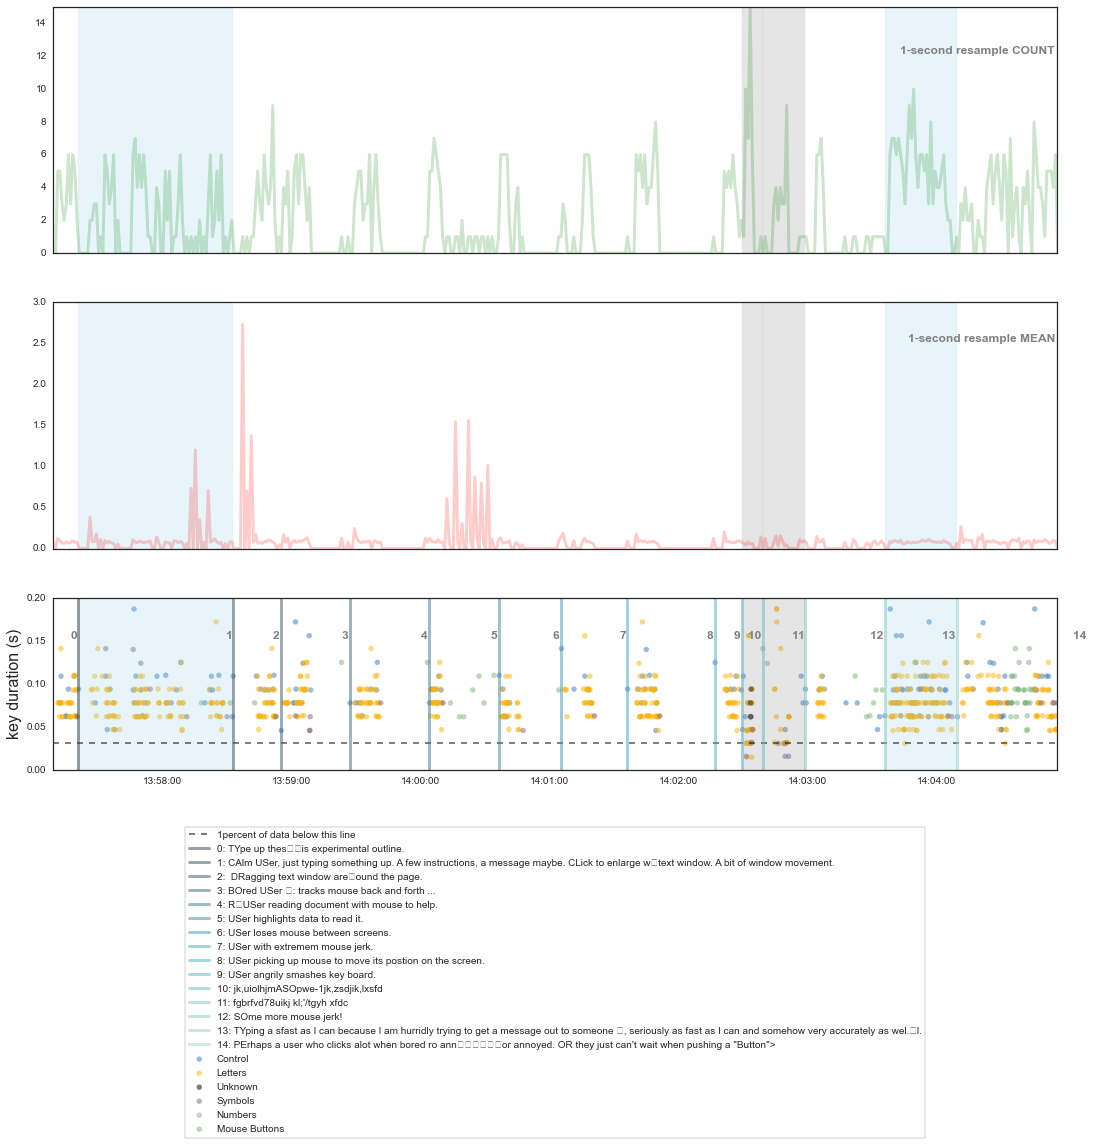

In [27]:
bf.printKeyDuration(durationDF,labelsDF,activeRanges)

Again, there is a detectable difference in the mean key duration times between calm (*blue left*) and frantic (*blue right*) typing.

**The grey region shows keyboard smashing. This is where the very low duration times show up, *below* the 1% line.** As well, the counts spike here, where keys are being hit at the same time.

#Looking at Mouse Positions

In [28]:
mousedataDF['Datetime'] = pd.to_datetime(mousedataDF['time'],unit='ms')
mousedataDF=mousedataDF.set_index('Datetime')
mousedataDF.index = pd.DatetimeIndex(mousedataDF.index)
mousedataDF.index.names = ["Datetime"]
mousedataDF.head()

,time,x,y
Datetime,,,
2015-04-22 13:57:06.338000,1429711026338,91,112
2015-04-22 13:57:06.338000,1429711026338,92,113
2015-04-22 13:57:06.354000,1429711026354,94,114
2015-04-22 13:57:06.354000,1429711026354,96,115
2015-04-22 13:57:06.369000,1429711026369,102,117


As a first look at the mouse positional data, I will just plot it to see how the mouse moves around the screens. 

My set-up is thus:

* *Left-hand-side*: laptop screen

* *Right-hand-side*: larger extended display

(0, 3456)

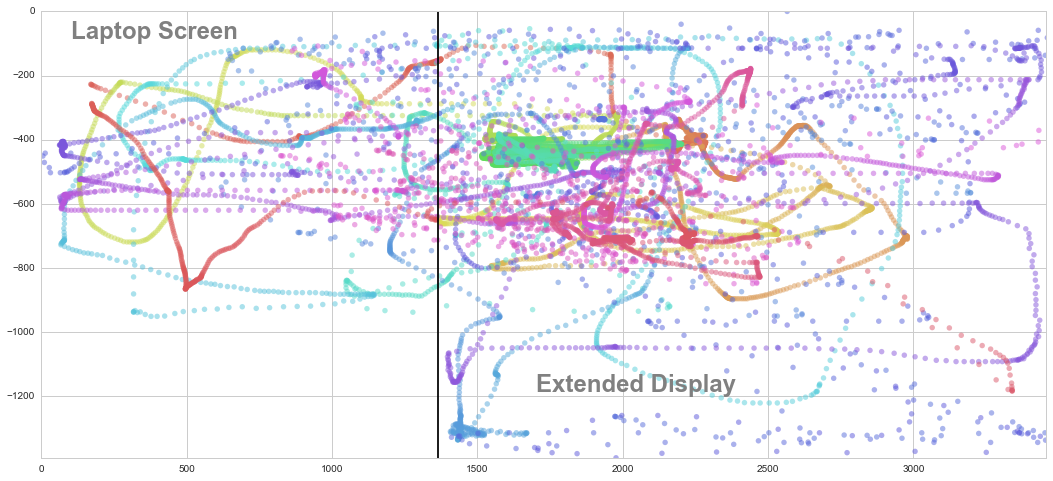

In [29]:
sns.set_style("whitegrid")
fig,ax = plt.subplots(figsize=(18,8))
colours = sns.color_palette('hls',len(mousedataDF))
xmax,xmin = mousedataDF['x'].max(),mousedataDF['x'].min()
ymax,ymin = mousedataDF['y'].max(),mousedataDF['y'].min()
xdata = [x-xmin+5 for x in mousedataDF['x']]
ydata = [-(y-ymin) for y in mousedataDF['y']]
ax.scatter(xdata,ydata,s=30,marker='o',c=colours,linewidths=0,alpha=0.5)
ax.plot([1366,1366],[ymin-ymax,0],color='k')
ax.text(100,-100,"Laptop Screen",fontsize=24,color='grey',weight="bold",horizontalalignment='left',verticalalignment='bottom')
ax.text(1700,-1200,"Extended Display",fontsize=24,color='grey',weight="bold",horizontalalignment='left',verticalalignment='bottom')
ax.set_ylim(ymin-ymax,0)
ax.set_xlim(0,xmin+xmax)

I can already pick out parts of the experiment, such as using the mouse to read text (*green*) and wildly moving the mouse back and forth (*points with larger distances between them*).

Below I will break up the mouse movements into the parts of the experiment.

In [30]:
mdDF = bf.getMouseDynamics(mousedataDF)

Eliminated  5183  data points where the speed of the mouse was faster than the key-capture program could record.


#Mouse Velocity

Measured as *pixels per millisecond*. 

For plotting purposes I have normalized the mouse velocity to the max.

In [31]:
vmax = mdDF['v'].max()
vDF = pd.DataFrame({'vnorm': pd.Series([v/vmax for v in mdDF['v']],index=mdDF.index)})
vDF.head()

,vnorm
DateTime,
2015-04-22 13:57:06.338000,0.000000
2015-04-22 13:57:06.354000,0.005709
2015-04-22 13:57:06.369000,0.014430
2015-04-22 13:57:06.385000,0.022670
2015-04-22 13:57:06.401000,0.043072


##Looking at mouse movement and velocity side-by-side

On the left-hand-side is mouse movement on the screen(s) for each part of the experiment.

The *white diamonds* correspond to left-mouse-button clicks, and the *black diamonds* to right-button-clicks.

The mouse travel path is starts in the dark colour and proceeds to the lightest.

Mouse velocity (normalized) is plotted on the right. 

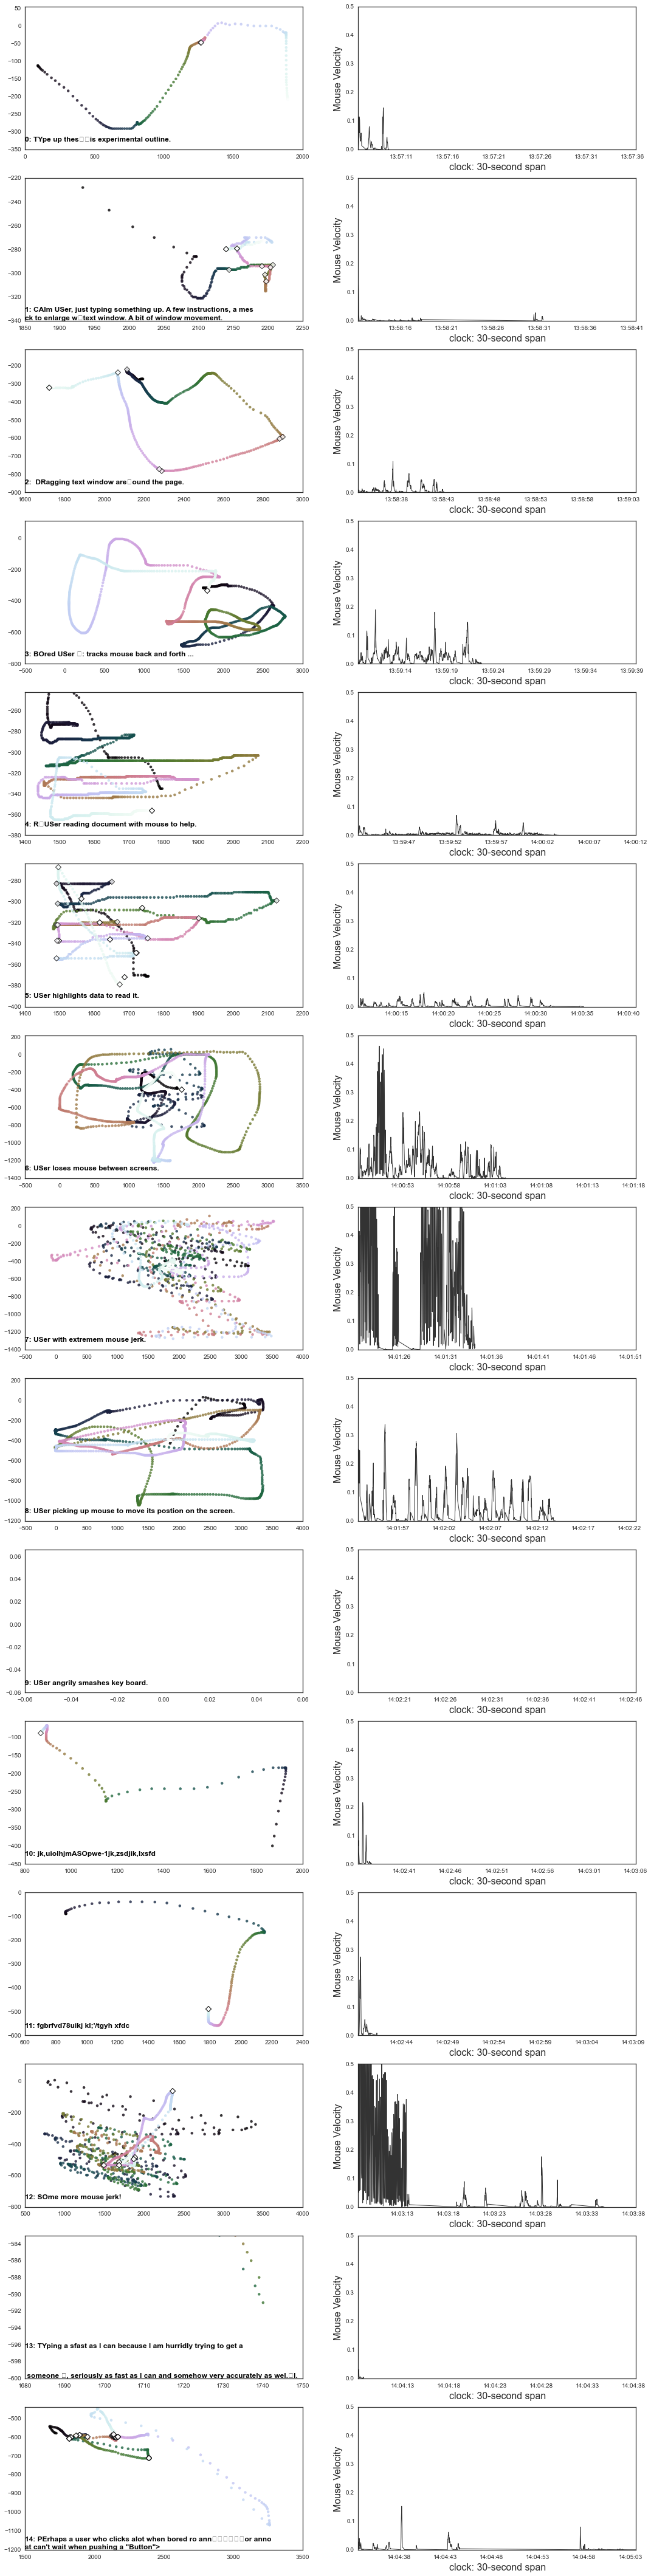

In [32]:
bf.printmouseVelocity(mousedataDF,keydataDF,vDF,labelsDF)

In **panels 4 and 5**, I am using the mouse to aid in reading a paragraph. Very **periodic behaviour can be detected** in the mouse velocity, whereas regular mouse use will have short velocity spikes at random interavls.

In **panels 6, 7 and 12**, I am jerking the mouse back and fourth. In the first instance I have lost the mouse between my two displays (since they are different sizes. It happens.). In the latter two, I am mimiking observed behaviour in frustrarted users under experimental conditions. The effect in the mouse is obvious, as spikes are high and densely packed in time.

It may be possible to set some threshold values for mouse velocity that could alert a monitoring program.